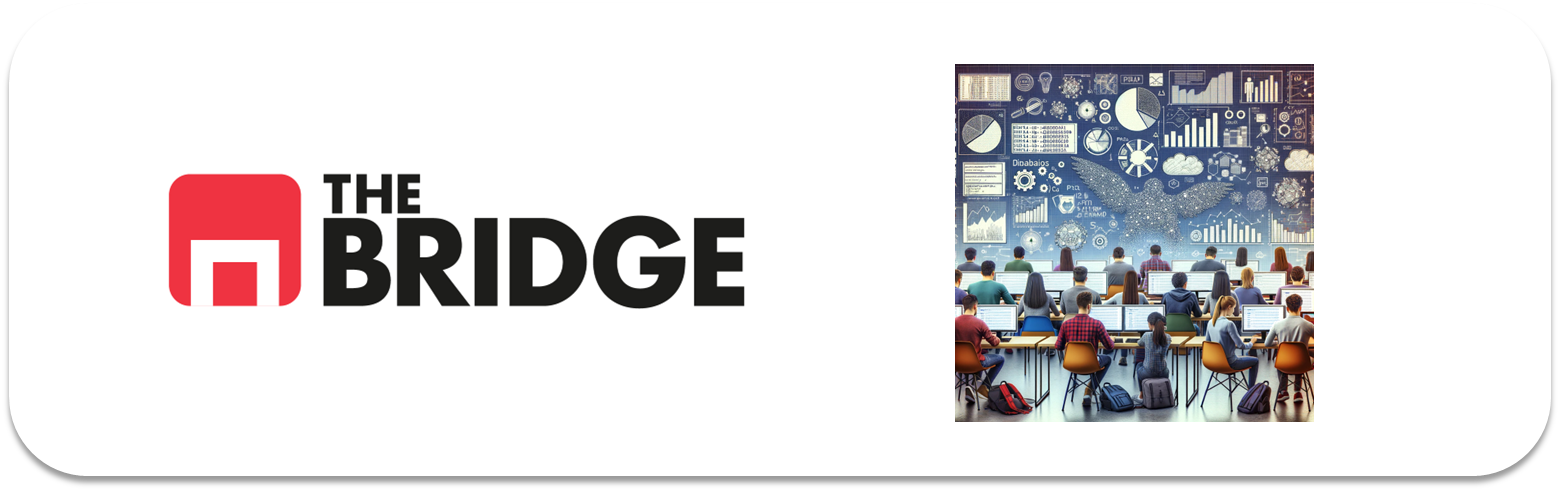

## TEAM CHALLENGE: TOOLBOX (I)

### IMPORTAR LIBRERIAS

In [2]:
# Importar librerias para manipulacion de datos
import pandas as pd
import numpy as np

# Importar librerias para analisis de datos
from scipy.stats import pearsonr
from scipy.stats import f_oneway, kruskal, ttest_ind, mannwhitneyu

# Importar librerias para visualizacion
import seaborn as sns
import matplotlib.pyplot as plt

### importar Dataframe


In [ ]:
df = pd.read_csv("./data/boston.csv", sep = "|")
#target "price"

### Funcion describe_df
funcion que analiza un data frame y devuelve otro dataframe con los siguientes datos para cada una de las columnas o variables:
- Tipo de dato
- Datos nulos
- Valores únicos
- Cardinalidad

In [4]:
def describe_df(df):
    
    """
    La función hace un breve resumen de las variables de un dataset, obteniendo datos relevantes para el posterior analisis
    Tipo de dato, Suma de valores nulos, valores únicos y cardinalidad.
    
    Argumentos:
    df (pd.DataFrame): DataFrame con los datos a analizar
    
    Retorna
    summary (pd.DataFrame): DataFrame con los valores para cada variable (Tipo de dato, % valores Nulos, Valores únicos, cardinalidad)
    """   
    
    # Crear un diccionario para almacenar los resultados
    resumen_datos = {
        "DATE_TYPE": df.dtypes.astype(str),
        "MISSINGS(%)": (df.isnull().mean() * 100).round(2),
        "UNIQUE_VALUES": df.nunique(),
        "CARDIN(%)": ((df.nunique() / len(df)) * 100).round(2)
    }
    
    # Convertir el diccionario en un DataFrame y transponerlo
    summary = pd.DataFrame(resumen_datos).T

    # Renombrar el índice como 'COL_N'
    summary.columns.name = 'COL_N'
    return summary

In [5]:
describe_df(df)

COL_N,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
DATE_TYPE,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
MISSINGS(%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,504,26,76,2,81,446,356,412,9,66,46,455,229
CARDIN(%),99.6,5.14,15.02,0.4,16.01,88.14,70.36,81.42,1.78,13.04,9.09,89.92,45.26


### funcion Tipifica_variables

In [11]:
def tipifica_variables(df, umbral_categoria=10, umbral_continua=30):
    """
    La función hace una tipificación de las variables de un dataset, obteniendo datos relevantes para el posterior análisis.

    Argumentos:
    df (pd.DataFrame): DataFrame con los datos a analizar.
    umbral_categoria (int): Valor de cardinalidad a partir del cual se considera una variable categórica.
    umbral_continua (int): Porcentaje de cardinalidad a partir del cual se considera una variable continua.

    Retorna:
    pd.DataFrame: DataFrame con los nombres de las variables, el tipo de variable sugerido en función de la cardinalidad
                  y el porcentaje de variación de la misma, además del dtype original de cada variable.
    """
    # Preparar el dataset con cardinalidades, % variación cardinalidad, y tipos
    df_tip = pd.DataFrame({
        'nombre_variable': df.columns,
        'Card': df.nunique(),
        '%_Card': df.nunique() / len(df) * 100,
        'dtype': df.dtypes.astype(str)
    })

    # Corrección para cuando solo tengo un valor
    df_tip.loc[df_tip['Card'] == 1, '%_Card'] = 0.00

    # Crear la columna de sugerencia de tipo de variable
    df_tip['tipo_sugerido'] = 'Categorica'
    df_tip.loc[df_tip['Card'] == 2, 'tipo_sugerido'] = 'Binaria'
    df_tip.loc[df_tip['Card'] >= umbral_categoria, 'tipo_sugerido'] = 'Numerica discreta'
    df_tip.loc[df_tip['%_Card'] >= umbral_continua, 'tipo_sugerido'] = 'Numerica continua'

    # Eliminar las columnas auxiliares que no me interesan
    df_tip = df_tip.reset_index().drop(['Card', '%_Card','COL_N'], axis=1)

    return df_tip

In [12]:
tipifica_variables(df)

,nombre_variable,dtype,tipo_sugerido
0,CRIM,float64,Numerica continua
1,ZN,float64,Numerica discreta
2,INDUS,float64,Numerica discreta
3,CHAS,float64,Binaria
4,NOX,float64,Numerica discreta
5,RM,float64,Numerica continua
6,AGE,float64,Numerica continua
7,DIS,float64,Numerica continua
8,RAD,float64,Categorica
9,TAX,float64,Numerica discreta


### Funcion get_features_num_refression

In [13]:
def get_features_num_regression(df, target_col, umbral_corr, pvalue=None):
    """
    Filtra las columnas numéricas de un DataFrame según su correlación con una columna objetivo que debe ser numérica continua.

    Argumentos:
        df (pd.DataFrame): DataFrame que contiene los datos.
        target_col (str): Nombre de la columna objetivo que debe ser numérica y continua.
        umbral_corr (float): Valor entre 0 y 1 que indica el umbral mínimo de correlación en valor absoluto.
        pvalue (float, optional): Valor entre 0 y 1. Si se especifica, las columnas también deben pasar un 
                                  test de hipótesis con un p-valor mayor o igual a (1 - pvalue).

    Retorna:
        pd.DataFrame: Un DataFrame con las columnas seleccionadas, sus valores absolutos de correlación y los p-valores,
                      ordenados de mayor a menor por la correlación absoluta.
               Si algún argumento no es válido, devuelve None e imprime un mensaje de error.
    """
    # Comprobaciones iniciales

    # Verificar si el argumento 'df' es un DataFrame
    if not isinstance(df, pd.DataFrame):
        print("El argumento 'df' no es un DataFrame válido.")
        return None

    # Comprobar si la columna objetivo existe en el DataFrame
    if target_col not in df.columns:
        print(f"La columna '{target_col}' no existe en el DataFrame.")
        return None

    # Comprobar que la columna objetivo es numérica y no es de tipo object ni string
    df_tipo = tipifica_variables(df)
    fila = df_tipo.loc[df_tipo["nombre_variable"] == target_col]
    if fila.empty:
        print(f"La columna '{target_col}' no existe en la salida de tipifica_variables.")
        return None
    tipo_variable = fila["dtype"].values[0]
    if tipo_variable in ["object", "string"]:
        print(f"La columna '{target_col}' es de tipo {tipo_variable} y no es válida como columna objetivo.")
        return None

    # Validar que el umbral de correlación esté en el rango [0, 1]
    if not (0 <= umbral_corr <= 1):
        print("El valor de 'umbral_corr' debe estar entre 0 y 1.")
        return None

    # Validar que el pvalue esté en el rango [0, 1] o sea None
    if pvalue is not None and not (0 <= pvalue <= 1):
        print("El valor de 'pvalue' debe estar entre 0 y 1 o ser None.")
        return None

    # Seleccionar columnas numéricas continuas del DataFrame según tipifica_variables, y que no sean tipo object ni string
    columnas_continuas = df_tipo[(df_tipo["tipo_sugerido"] == "Numerica continua") & (~df_tipo["dtype"].isin(["object", "string"]))]["nombre_variable"].tolist()
    columnas_continuas = [col for col in columnas_continuas if col in df.columns and col != target_col] # Excluir la columna objetivo

    # Diccionario para almacenar las correlaciones y p-valores que cumplen los criterios
    resultados_filtrados = []

    # Iterar sobre cada columna numérica continua
    for col in columnas_continuas:
        # Intentar convertir las columnas a tipo numérico, descartando valores no convertibles
        try:
            target_data = pd.to_numeric(df[target_col], errors='coerce').dropna()
            col_data = pd.to_numeric(df[col], errors='coerce').dropna()

            # Asegurar que ambas columnas tengan suficientes datos para calcular la correlación
            if len(target_data) > 1 and len(col_data) > 1:
                # Calcular correlación y p-valor usando scipy.stats.pearsonr
                correlacion, p_valor = pearsonr(target_data, col_data)

                # Comprobar si la correlación supera el umbral
                if np.abs(correlacion) >= umbral_corr:
                    if pvalue is not None:
                        # Comprobar si el p-valor cumple el criterio
                        if (1 - p_valor) >= (1 - pvalue):
                            resultados_filtrados.append({
                                'variable': col,
                                'correlacion_absoluta': np.abs(correlacion),
                                'p_valor': p_valor
                            })
                    else:
                        # Agregar la columna si no se considera el p-valor
                        resultados_filtrados.append({
                            'variable': col,
                            'correlacion_absoluta': np.abs(correlacion),
                            'p_valor': p_valor
                        })
        except Exception as e:
            print(f"Error al procesar la columna '{col}': {e}")

    # Crear un DataFrame con los resultados ordenados por correlación absoluta
    df_corr = pd.DataFrame(resultados_filtrados)
    if not df_corr.empty:
        df_corr = df_corr.sort_values(by='correlacion_absoluta', ascending=False).reset_index(drop=True)

    # Devolfver el DataFrame con las columnas seleccionadas, correlaciones y p-valores
    return df_corr

In [25]:
get_features_num_regression(df,"MEDV",0.2,0.05)

,variable,correlacion_absoluta,p_valor
0,LSTAT,0.737663,5.081103e-88
1,RM,0.695360,2.487229e-74
2,CRIM,0.388305,1.173987e-19
3,AGE,0.376955,1.569982e-18
4,DIS,0.249929,1.206612e-08


### Funcion plot_features_num_regression

In [15]:
def plot_features_num_regression(df, target_col="", columns=[], umbral_corr=0, pvalue=None):
    """
    Genera pairplots basados en la correlación entre una columna objetivo y otras columnas numéricas o seleccionadas.

    Argumentos:
        df (pd.DataFrame): DataFrame que contiene los datos.
        target_col (str): Nombre de la columna objetivo que debe ser numérica y continua.
        columns (list of str): Lista de columnas a evaluar. Si está vacía, se usan todas las columnas numéricas del DataFrame.
        umbral_corr (float): Valor mínimo de correlación en valor absoluto (entre 0 y 1).
        pvalue (float, optional): Valor entre 0 y 1. Si se especifica, las columnas también deben pasar un test 
                                  de hipótesis con un p-valor mayor o igual a (1 - pvalue).

    Retorna:
        list: Lista de nombres de columnas que cumplen los criterios de correlación y p-valor. Si algún argumento no
              es válido, devuelve None e imprime un mensaje de error.
    """
    # Comprobaciones iniciales

    # Verificar si el argumento 'df' es un DataFrame
    if not isinstance(df, pd.DataFrame):
        print("El argumento 'df' no es un DataFrame válido.")
        return None

    # Comprobar si la columna objetivo es válida, porque está en el DataFrame
    if target_col == "" or target_col not in df.columns:
        print("Debe proporcionar una columna objetivo válida en 'target_col'.")
        return None

    # Comprobar que la columna objetivo es numérica continua y no es de tipo object ni string
    df_tipo = tipifica_variables(df)
    fila = df_tipo.loc[df_tipo["nombre_variable"] == target_col]
    if fila.empty:
        print(f"La columna '{target_col}' no existe en la salida de tipifica_variables.")
        return None
    tipo_variable = fila["dtype"].values[0]
    if tipo_variable in ["object", "string"]:
        print(f"La columna '{target_col}' es de tipo {tipo_variable} y no es válida como columna objetivo.")
        return None
    
    # Validar que el umbral de correlación esté en el rango [0, 1]
    if not (0 <= umbral_corr <= 1):
        print("El valor de 'umbral_corr' debe estar entre 0 y 1.")
        return None

    # Validar que el pvalue esté en el rango [0, 1] o sea None
    if pvalue is not None and not (0 <= pvalue <= 1):
        print("El valor de 'pvalue' debe estar entre 0 y 1 o ser None.")
        return None

    # Selección de features numericas
    # Si 'columns' está vacío, considerar todas las columnas numéricas del DataFrame
    if columns == []:    
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
        columns.remove(target_col)

    # Filtrar columnas que cumplan los criterios de correlación y p-value
    columnas_filtradas = []
    for col in columns:
        
        # Comprobar si las columnas especificadas existen en el DataFrame
        if col not in df.columns:
            print(f"La columna '{col}' no existe en el DataFrame. Se ha ignorado.")
            continue

        # Comprobar si la columna es numérica continua según tipifica_variables, y que no es ni object ni string
        fila_col = df_tipo.loc[df_tipo["nombre_variable"] == col]
        if fila_col.empty or fila_col["tipo_sugerido"].values[0] != "Numerica continua" or fila_col["dtype"].values[0] in ["object", "string"]:
            print(f"La columna '{col}' se ha ignorado porque no cumple los requisitos de ser variable numérica continua.")
            continue

        # Calcular correlación y p-valor usando pearsonr
        correlacion, p_valor = pearsonr(df[target_col].dropna(), df[col].dropna())

        # Comprobar correlación y p-value
        if np.abs(correlacion) >= umbral_corr:
            if pvalue is not None:
                if (1-p_valor) >= (1 - pvalue):
                    columnas_filtradas.append(col)
            else:
                columnas_filtradas.append(col)

    # Generar pairplots en grupos de máximo 5 columnas
    max_columns = 5
    for i in range(0, len(columnas_filtradas), max_columns - 1):
        subset = [target_col] + columnas_filtradas[i:i + max_columns - 1]
        sns.pairplot(
            df[subset].dropna(), 
            kind='reg', 
            diag_kind='kde', 
            plot_kws={'scatter_kws': {'alpha': 0.5}, 'line_kws': {'color': 'red'}}
        )
        plt.show()

    return columnas_filtradas

La columna 'ZN' se ha ignorado porque no cumple los requisitos de ser variable numérica continua.
La columna 'INDUS' se ha ignorado porque no cumple los requisitos de ser variable numérica continua.
La columna 'CHAS' se ha ignorado porque no cumple los requisitos de ser variable numérica continua.
La columna 'NOX' se ha ignorado porque no cumple los requisitos de ser variable numérica continua.
La columna 'RAD' se ha ignorado porque no cumple los requisitos de ser variable numérica continua.
La columna 'TAX' se ha ignorado porque no cumple los requisitos de ser variable numérica continua.
La columna 'PTRATIO' se ha ignorado porque no cumple los requisitos de ser variable numérica continua.


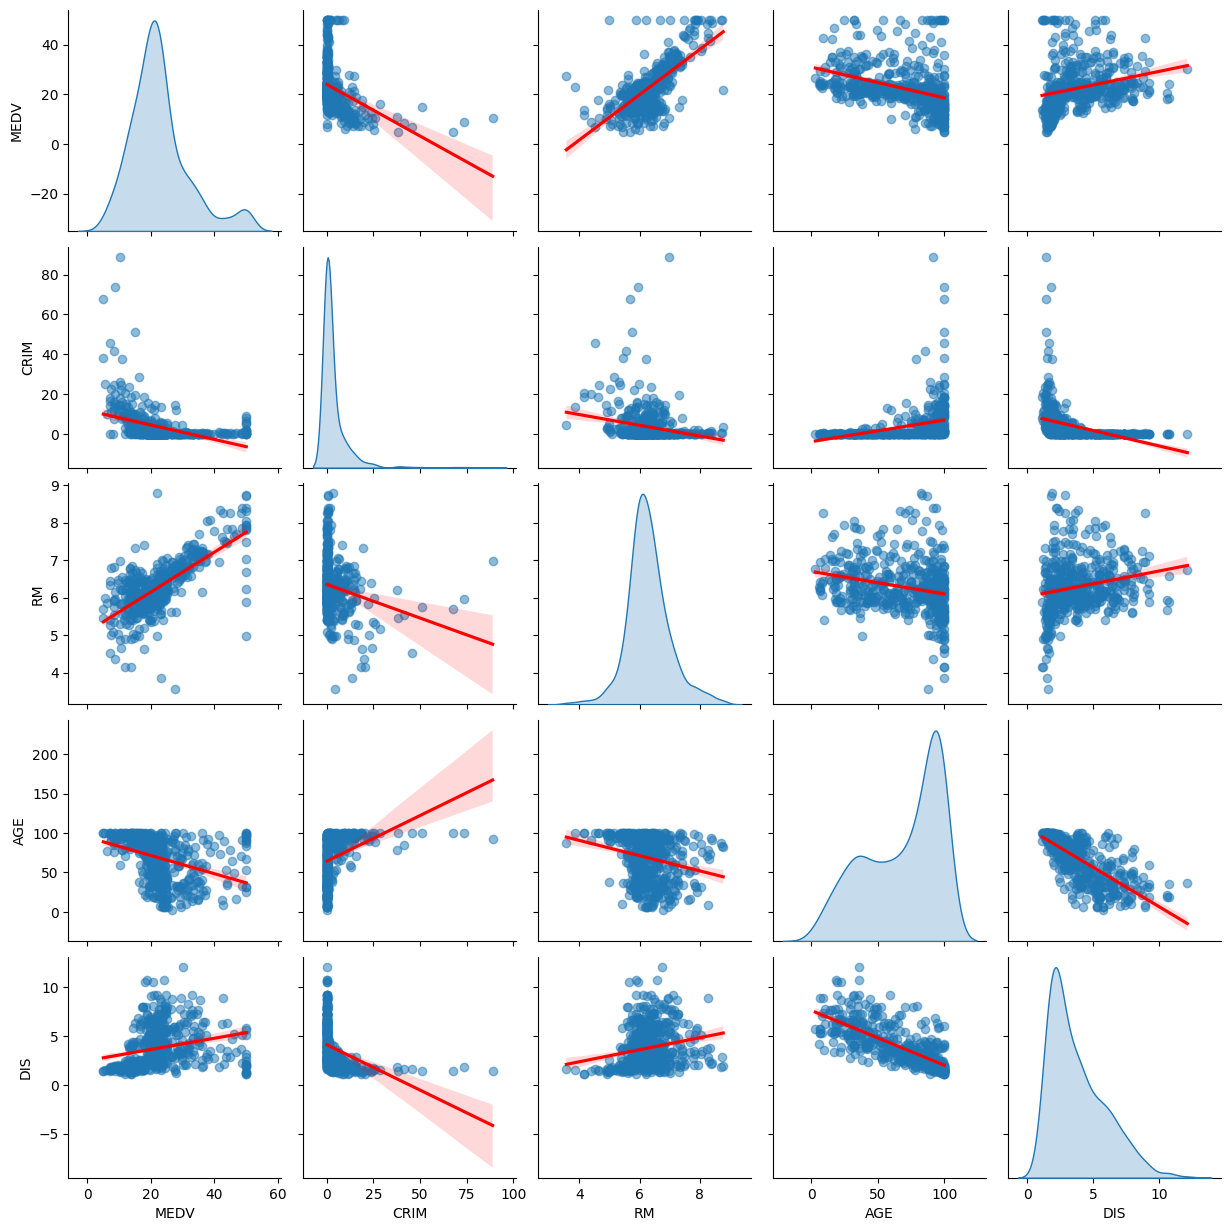

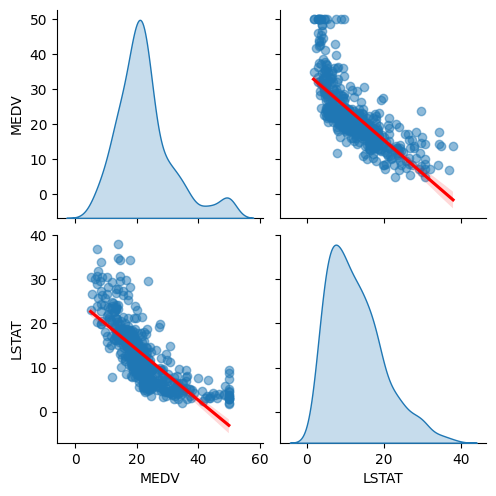

['CRIM', 'RM', 'AGE', 'DIS', 'LSTAT']

In [16]:
#def plot_features_num_regression(df, target_col="", columns=[], umbral_corr=0, pvalue=None):
plot_features_num_regression(df,"MEDV")

### Funcion get_features_cat_regression

In [27]:
def get_features_cat_regression(df, target_col, pvalue=0.05, normal_distribution=False):
    """
    Selecciona columnas categóricas relacionadas con la columna objetivo según pruebas estadísticas.

    Argumentos:
        df (pd.DataFrame): DataFrame con los datos.
        target_col (str): Nombre de la columna objetivo. Debe ser numérica continua.
        pvalue (float): Valor de corte para el test estadístico. Valor por defecto: 0.05.
        normal_distribution (bool): Indica si la variable objetivo tiene distribución normal. Valor por defecto: False.

    Retorna:
        list: Lista de columnas categóricas relacionadas estadísticamente con la columna objetivo.
              Si algún argumento no es válido, devuelve None e imprime un mensaje de error.
    """
    # Comprobaciones iniciales
    if not isinstance(df, pd.DataFrame):
        print("El argumento 'df' no es un DataFrame válido.")
        return None

    # Verificar si la columna objetivo está en el DataFrame
    if target_col not in df.columns:
        print(f"La columna objetivo '{target_col}' no está en el DataFrame.")
        return None

    # Verificar que target_col sea numérica continua, según tipifica_variables, y no sea de tipo object ni string
    df_tipo = tipifica_variables(df)
    fila = df_tipo.loc[df_tipo["nombre_variable"] == target_col]
    if fila.empty:
        print(f"La columna '{target_col}' no existe en la salida de tipifica_variables.")
        return None
    tipo_variable = fila["dtype"].values[0]
    if tipo_variable in ["object", "string"]:
        print(f"La columna '{target_col}' es de tipo {tipo_variable} y no es válida como columna objetivo.")
        return None

    # Filtrar columnas categóricas
    categoricas = df.select_dtypes(include=["object", "category"]).columns.tolist()
    if not categoricas:
        print("No se encontraron columnas categóricas en el DataFrame.")
        return []

    # Lista para almacenar las columnas que pasan el test estadístico
    columnas_significativas = []

    for col in categoricas:
        # Verificar si la columna categórica tiene al menos 2 categorías
        if df[col].nunique() < 2:
            print(f"La columna '{col}' tiene menos de 2 categorías y no se considerará.")
            continue

        # Crear grupos basados en la variable categórica
        grupos = [df[target_col][df[col] == cat].dropna() for cat in df[col].unique()]

        # Verificar si los grupos tienen suficientes datos
        if any(len(grupo) < 2 for grupo in grupos):
            print(f"La columna '{col}' tiene categorías con datos insuficientes y no se considerará.")
            continue

        # Seleccionar el test estadístico según el número de categorías
        try:
            if len(grupos) == 2:
                if normal_distribution:
                    # Prueba t para variables binarias si la distribución es normal
                    estadistico, p_valor = ttest_ind(grupos[0], grupos[1])
                else:
                    # Prueba de Mann-Whitney U si la distribución no es normal
                    estadistico, p_valor = mannwhitneyu(grupos[0], grupos[1], alternative='two-sided')
            elif len(grupos) > 2:
                # ANOVA para más de dos categorías si la distribución es normal
                estadistico, p_valor = f_oneway(*grupos)
        except ValueError:
            # Si ANOVA falla (posiblemente por normalidad), intentar Kruskal-Wallis
            estadistico, p_valor = kruskal(*grupos)

        # Comprobar si el p-valor cumple con el umbral
        if p_valor <= pvalue:
            columnas_significativas.append(col)
        else:
            print(f"La columna '{col}' no supera el test estadístico (p-valor = {p_valor:.3f}).")

    return columnas_significativas

In [30]:
get_features_cat_regression(df,"MEDV")

No se encontraron columnas categóricas en el DataFrame.


[]

In [17]:
import pandas as pd

import scipy.stats as stats

def S_get_features_cat_regression(df, target_col, pvalue=0.05):
    """
    Esta función recibe como argumentos un dataframe, el nombre de una de la columna target del mismo (target_col)
    y una variable float pvalue cuyo valor por defecto será 0.05.
    
    La función devuelve una lista con las columnas categóricas del dataframe cuyo test de relación con la columna designada por 'target_col'
    supere en confianza estadística el test de relación necesario.
    
    Argumentos:
    df (pd.DataFrame): El dataframe de entrada.
    target_col (str): El nombre de la columna objetivo.
    pvalue (float): El valor p para el test de relación. Valor por defecto es 0.05.
    
    Retorna:
    list: Lista de columnas categóricas que cumplen con el test de relación.
    """
    
    #Comprobaciones de los valores de entrada. La columna debe existir en el dataframe, ser numérica y el valor de pvalue debe estar entre 0 y 1.
    if target_col not in df.columns:
        print(f"Error: La columna '{target_col}' no está presente en el dataframe.")
        return None
    
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print(f"Error: La columna '{target_col}' no es es de tipo numérico.")
        return None
    
    if not (0 < pvalue < 1):
        print("Error: El valor de 'pvalue' debe estar entre 0 y 1.")
        return None
    
    #Lista para almacenar las columnas categóricas que cumplen con el test de relación
    columnas_validas = []
    
    #Iterar sobre las columnas del dataframe
    for columna in df.columns:
        if columna != target_col and pd.api.types.is_categorical_dtype(df[columna]):
            #Realizar el test de contingencia
            contingency_table = pd.crosstab(df[columna], df[target_col])
            chi2, p, _, _ = stats.chi2_contingency(contingency_table)
            #Si el p-valor es menor que el valor de pvalue, se añade la columna a la lista de columnas válidas
            if p < pvalue:
                columnas_validas.append(columna)
    
    return columnas_validas

In [18]:
S_get_features_cat_regression(df,"MEDV")

[]

### plot_features_cat_regression

In [32]:

def plot_features_cat_regression(df, target_col="", columns=[], pvalue=0.05, with_individual_plot=False, normal_distribution=False):
    """
    Genera histogramas agrupados de la variable "target_col" para cada una de las variables categóricas
    que cumplen el criterio de significación estadística.

    Argumentos:
        df (pd.DataFrame): DataFrame con los datos.
        target_col (str): Nombre de la columna objetivo. Debe ser numérica continua.
        columns (list of str): Lista de columnas categóricas a evaluar. Si está vacía, se usarán todas las categóricas.
        pvalue (float): Nivel de significación estadística. Valor por defecto: 0.05.
        with_individual_plot (bool): Si es True, genera histogramas individuales para cada columna significativa.
        normal_distribution (bool): Indica si la variable objetivo tiene distribución normal. Valor por defecto: False.

    Retorna:
        list: Lista de columnas categóricas que cumplen el criterio de significación estadística.
    """
    # Comprobaciones iniciales
    if not isinstance(df, pd.DataFrame):
        print("El argumento 'df' no es un DataFrame válido.")
        return None

    # Verificar si la columna objetivo está en el DataFrame
    if target_col not in df.columns:
        print(f"La columna objetivo '{target_col}' no está en el DataFrame.")
        return None

    # Verificar que target_col sea numérica continua, según tipifica_variables, y no sea de tipo object ni string
    df_tipo = tipifica_variables(df)
    fila = df_tipo.loc[df_tipo["nombre_variable"] == target_col]
    if fila.empty:
        print(f"La columna '{target_col}' no existe en la salida de tipifica_variables.")
        return None
    tipo_variable = fila["dtype"].values[0]
    if tipo_variable in ["object", "string"]:
        print(f"La columna '{target_col}' es de tipo {tipo_variable} y no es válida como columna objetivo.")
        return None

    # Si 'columns' está vacío, seleccionar todas las columnas categóricas
    if not columns:
        columns = df.select_dtypes(include=["object", "category"]).columns.tolist()

    # Comprobar si hay columnas categóricas
    if not columns:
        print("No se encontraron columnas categóricas en el DataFrame.")
        return []

    # Filtrar columnas significativas
    columnas_significativas = []

    for col in columns:
        # Verificar si la columna categórica tiene al menos 2 categorías
        if df[col].nunique() < 2:
            print(f"La columna '{col}' tiene menos de 2 categorías y no se considerará.")
            continue

        # Crear grupos basados en la variable categórica
        grupos = [df[target_col][df[col] == cat].dropna() for cat in df[col].unique()]

        # Verificar si los grupos tienen suficientes datos
        if any(len(grupo) < 2 for grupo in grupos):
            print(f"La columna '{col}' tiene categorías con datos insuficientes y no se considerará.")
            continue

        # Seleccionar el test estadístico
        try:
            if len(grupos) == 2:
                if normal_distribution:
                    # Prueba t para variables binarias si la distribución es normal
                    estadistico, p_valor = ttest_ind(grupos[0], grupos[1])
                else:
                    # Prueba de Mann-Whitney U si la distribución no es normal
                    estadistico, p_valor = mannwhitneyu(grupos[0], grupos[1], alternative='two-sided')
            else:
                if normal_distribution:
                    # ANOVA para datos con distribución normal
                    estadistico, p_valor = f_oneway(*grupos)
                else:
                    # Kruskal-Wallis para datos sin distribución normal
                    estadistico, p_valor = kruskal(*grupos)
        except ValueError:
            print(f"La columna '{col}' no pudo ser evaluada debido a problemas en los datos.")
            continue

        # Comprobar si el p-valor cumple con el umbral
        if p_valor <= pvalue:
            columnas_significativas.append(col)

    # Generar gráficos solo para las columnas significativas
    if with_individual_plot:
        for col in columnas_significativas:
            plt.figure(figsize=(10, 6))
            for valor in df[col].unique():
                sns.histplot(df.loc[df[col] == valor,target_col], kde= True, label=valor,bins=40)
 
            plt.title(f"Histograma de {target_col} agrupado por {col} (p-valor = {p_valor:.3f})")
            plt.xlabel(target_col)
            plt.ylabel("Frecuencia")
            plt.legend();  
            plt.show()
     
    else:
        num_plots = len(columnas_significativas)
        if num_plots > 0:
            num_cols = 2
            num_rows = (num_plots + 1) // num_cols

            fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
            axes = axes.flatten()

            for i, col in enumerate(columnas_significativas):
                for valor in df[col].unique():
                    sns.histplot(df.loc[df[col] == valor,target_col], kde= True, label=valor, ax=axes[i],bins=40)
                axes[i].set_title(f"Histograma de {target_col} agrupado por {col} (p-valor = {p_valor:.3f})")
                axes[i].set_xlabel(target_col)
                axes[i].set_ylabel("Frecuencia")
                axes[i].legend()

            # Eliminar axes no utilizados
            for j in range(i + 1, len(axes)):
                fig.delaxes(axes[j])

            plt.tight_layout()
            plt.show()

    return columnas_significativas


In [33]:
plot_features_cat_regression(df,"MEDV")

No se encontraron columnas categóricas en el DataFrame.


[]

In [19]:
import seaborn as sns

import matplotlib.pyplot as plt

def S_plot_features_cat_regression(df, target_col="", columns=[], pvalue=0.05, with_individual_plot=False):
    """
    Esta función recibe un dataframe, un argumento "target_col" con valor por defecto "", una lista de strings ("columns") cuyo valor por defecto es la lista vacía,
    un argumento ("pvalue") con valor 0.05 por defecto y un argumento "with_individual_plot" a False.
    
    Si la lista no está vacía, la función pintará los histogramas agrupados de la variable "target_col" para cada uno de los valores de las variables categóricas
    incluidas en columns que cumplan que su test de relación con "target_col" es significativo para el nivel 1-pvalue de significación estadística.
    La función devolverá los valores de "columns" que cumplan con las condiciones anteriores.
    
    Si la lista está vacía, entonces la función igualará "columns" a las variables categóricas del dataframe y se comportará como se describe en el párrafo anterior.
    
    De igual manera que en la función `get_features_cat_regression`, deberá hacer un check de los valores de entrada y comportarse como se describe en el último párrafo
    de la función `get_features_cat_regression`.
    
    Argumentos:
    df (pd.DataFrame): El dataframe de entrada.
    target_col (str): El nombre de la columna objetivo.
    columns (list): Lista de columnas categóricas a considerar. Valor por defecto es la lista vacía.
    pvalue (float): El valor p para el test de relación. Valor por defecto es 0.05.
    with_individual_plot (bool): Si es True, se pintarán histogramas individuales para cada variable categórica. Valor por defecto es False.
    
    Retorna:
    list: Lista de columnas categóricas que cumplen con el test de relación.
    """
    
    #Comprobaciones de los valores de entrada. La columna debe estar en el dataframe, ser de tipo numérica y el valor de pvalue debe estar entre 0 y 1.
    #Si no se ha introducido ninguna columna, se toman las columnas categóricas del dataframe.
    if target_col not in df.columns:
        print(f"Error: La columna '{target_col}' no existe en el dataframe.")
        return None
    
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print(f"Error: La columna '{target_col}' no es una variable numérica continua.")
        return None
    
    if not (0 < pvalue < 1):
        print("Error: El valor de 'pvalue' debe estar entre 0 y 1.")
        return None
    
    if columns == []:
        columns = df.select_dtypes(include=['category']).columns.tolist()
    
    #Lista para almacenar las columnas categóricas que cumplen con el test inferior
    columnas_validas = []
    
    #Iterar sobre las columnas del dataframe
    for columna in columns:
        if columna != target_col and pd.api.types.is_categorical_dtype(df[columna]):
            #Realizar el test de chi2
            contingency_table = pd.crosstab(df[columna], df[target_col])
            chi2, p, _, _ = stats.chi2_contingency(contingency_table)
            
            if p < pvalue:
                columnas_validas.append(columna)
    
    #Se dibuja el histograma de la columnas validas que han pasado el test
    if columnas_validas:

        #Si with_individual_plot es True, se pintarán histogramas individuales para cada variable categórica
        if with_individual_plot == True:
            for columna in columnas_validas:
                plt.figure(figsize=(10, 6))
                sns.histplot(data=df, x=target_col, hue=columna, multiple="stack", kde=True)
                plt.title(f'Histograma agrupado de {target_col} por {columna}')
                plt.show()

        #Si with_individual_plot es False, se pintarán histogramas agrupados en un plot conjunto para todas las variables categóricas
        else:
            num_plots = len(columnas_validas)
            num_cols = 2
            num_rows = (num_plots + 1) // num_cols

            fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
            axes = axes.flatten()

            for i, columna in enumerate(columnas_validas):
                sns.histplot(data=df, x=target_col, hue=columna, multiple="stack", kde=True, ax=axes[i])
                axes[i].set_title(f'Histograma agrupado de {target_col} por {columna}')

            #Se eliminan los "axes" que no se han utilizado
            for j in range(i + 1, len(axes)):
                fig.delaxes(axes[j])

            plt.tight_layout()
            plt.show()
    
    return columnas_validas

In [20]:
S_plot_features_cat_regression(df,"MEDV")

[]